# Light field and Lumigraph rendering

In [416]:
import os
import math
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Image as display_image
from tqdm import tqdm

In [3]:
from pathlib import Path

In [553]:
image_paths = list(Path('bunny/rectified/').resolve().glob('*.png'))

### Rename and resize light field images

### Renaming format is row_col.png. E.g. 0_0.png, 10_2.png

### Data should be downloaded here: http://lightfield.stanford.edu/lfs.html

In [305]:
# for path in tqdm(image_paths):
#     name = path.name
#     path = str(path)
#     col, row = name.split('_')[1:3]
#     col = str(int(col))
#     row = str(int(row))
#     image = cv2.imread(str(path), cv2.IMREAD_COLOR)
#     image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
#     cv2.imwrite('bunny/128/'+col+'_'+row+'.png', image)

100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [00:13<00:00, 21.22it/s]


In [554]:
# for path in tqdm(image_paths):
#     name = path.name
#     col, row = name.split('_')[1:3]
#     col = str(int(col))
#     row = str(int(row))
#     os.rename(str(path), os.path.join(str(path.parent), col+'_'+row+'.png'))

100%|██████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 3291.91it/s]


## A tool for visualizing light field datasets
### Mostly copied from https://github.com/WeiPhil/LightFieldImaging

In [33]:
slider_v = widgets.IntSlider(
    value=0,
    min=0,
    max=16,
    step=1,
    description='u:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

slider_u = widgets.IntSlider(
    value=0,
    min=0,
    max=16,
    step=1,
    description='v:',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='d'
)

slider_alpha = widgets.IntSlider(
    value=0,
    min=0,
    max=int(17/2),
    step=1,
    description='f-stop:',
)

slider_focus = widgets.FloatSlider(
    value=0,
    min=-2.0,
    max=2.0,
    step=0.05,
    description='C:'
)

def renderer(u, v):
    u = str(u)
    v = str(v)
    plt.figure(figsize = (9,9))
    image = cv2.imread('lego/128/'+u+'_'+v+'.png', cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [34]:
interact(renderer, u=slider_u,v=slider_v)

interactive(children=(IntSlider(value=0, continuous_update=False, description='v:', max=16, orientation='verti…

<function __main__.renderer(u, v)>

## Naive interpolation only along y axis

In [312]:
def synthesize_view(dataset='lego', interpolate=False):
    images = []
    if interpolate:
        step = 3
        savename = 'with_interpolation'
        duration = 0
    else:
        step = 10
        savename = 'without_interpolation'
        duration = 500
    for i in range(0, 170, step):
        j = 0
        u = i
        v = j
        v = str(v)
        if u % 10 == 0:
            u = u//10
            u = str(u)
            image = cv2.imread(dataset + '/128/'+u+'_'+v+'.png', cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            a = (u%10)/10
            u = u/10
            floor = str(math.floor(u))
            floor = cv2.imread(dataset + '/128/'+floor+'_'+v+'.png', cv2.IMREAD_COLOR)
            floor = cv2.cvtColor(floor, cv2.COLOR_BGR2RGB)
            ceil = str(math.ceil(u))
            ceil = cv2.imread(dataset + '/128/'+ceil+'_'+v+'.png', cv2.IMREAD_COLOR)
            if ceil is not None:
                ceil = cv2.cvtColor(ceil, cv2.COLOR_BGR2RGB)
                image = floor * (1-a) + ceil * a
            else:
                image = floor
        image = Image.fromarray(np.uint8(image))
        images.append(image)
    
    savename = dataset + '_' + savename + '.gif'
    images[0].save(savename, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)

## Comparing views with and without interpolation:

### Resolution is downsampled to 128*128

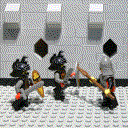

In [315]:
synthesize_view(dataset='lego', interpolate=False)
display_image('lego_without_interpolation.gif', width=300)

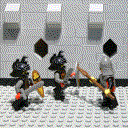

In [316]:
synthesize_view(dataset='lego', interpolate=True)
display_image('with_interpolation.gif', width=300)

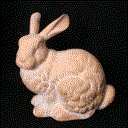

In [313]:
synthesize_view(dataset='bunny', interpolate=False)
display_image('bunny_without_interpolation.gif', width=300)

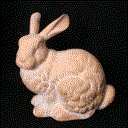

In [314]:
synthesize_view(dataset='bunny', interpolate=True)
display_image('bunny_with_interpolation.gif', width=300)

## Calculating refocused views
### Mostly copied from https://github.com/WeiPhil/LightFieldImaging
### For more on this Shift-And-Add Algorithm, see https://inst.eecs.berkeley.edu/~cs194-26/fa16/Lectures/light_fields.pdf

In [122]:
def render_focus(c, lf):
    image = np.zeros((128, 128, 3))
    center_uv = 8
    for u in range(17):
        for v in range(17):
            shift_x, shift_y = c * (center_uv-u), c * (center_uv-v)
            
            image[:,:] += shift(lf[u, v, :, :, :], (shift_x, shift_y, 0))
    image = image / 289
    image = Image.fromarray(np.uint8(image))
    return image

def render_focus_all():
    lf = np.zeros((17, 17, 128, 128, 3))
    print('loading')
    for u in range(17):
        for v in range(17):
            image = cv2.imread('lego/128/'+str(u)+'_'+str(v)+'.png', cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            lf[u, v, :, :, :] = image
            
    print('finished loading')
    
    final_render = []
    params = np.linspace(-3,3,20)
    for c in tqdm(params):
        focus = render_focus(c, lf)
        final_render.append(focus)
    return final_render

In [123]:
focused = render_focus_all()

loading


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

finished loading


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:12<00:00,  9.62s/it]


In [124]:
len(focused)

20

In [302]:
focused_trim = focused[5:-5]

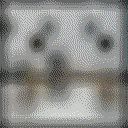

In [303]:
focused_trim[0].save('focued.gif', save_all=True, append_images=focused_trim[1:], optimize=False, duration=300, loop=0)
display_image('focued.gif', width=300)

## Calculating depth map as a geometric proxy

### depth map is much more accurate at the original resolution

### z is 0 at uv (pixel) plane and 1 at st (camera) plane

In [556]:
def get_depth(left, right, numDisparities, blocksize):
    imgL = cv2.imread(left)
    imgL = cv2.cvtColor(imgL,cv2.COLOR_BGR2GRAY)
    imgR = cv2.imread(right)
    imgR = cv2.cvtColor(imgR,cv2.COLOR_BGR2GRAY)
    stereo = cv2.StereoBM_create(
        numDisparities=numDisparities, 
        blockSize=blocksize,
    )
    depth = stereo.compute(imgL,imgR)
    depth = depth - depth.min()
    depth = depth / depth.max()
    print(depth.shape)
    plt.imshow(depth, 'gray')
    plt.show()
    return depth.clip(min=0, max=0.9)

(1024, 1024)


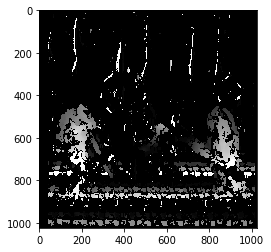

In [607]:
z = get_depth('lego/rectified/0_16.png', 'lego/rectified/0_0.png', numDisparities=32, blocksize=19)

(1024, 1024)


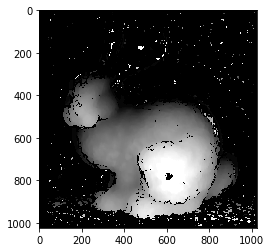

In [581]:
z = get_depth('bunny/rectified/0_0.png', 'bunny/rectified/0_16.png', numDisparities=32, blocksize=17)

## Lumigraph with depth correction

In [601]:
# Implementation of the core algorithm specified in Gortler et al.The Lumigraph. 1996.
def lumigraph_depth_correction(s, t, z, dataset='bunny'):
    # s and t should be in range(0, 16, 1). E.g. 1.2, 2.5, 10.6
    # z is depth map of (1024, 1024).
    # uv are two (1024, 1024) matrices of UV int coordinates
    u, v = np.meshgrid(list(range(0, 1024, 1)), list(range(0, 1024, 1)))
    result = np.zeros((1024, 1024, 3))
    s0 = math.floor(s)
    s1 = math.ceil(s)
    t0 = math.floor(t)
    t1 = math.ceil(t)
    for si, tj in [(s0, t0), (s0, t1), (s1, t0), (s1, t1)]:
        u_prime = u + (s-si)*z/(1-z) + 0.01
        v_prime = v + (t-tj)*z/(1-z) + 0.01
        u0 = np.floor(u_prime).astype(np.int64)
        u1 = np.ceil(u_prime).astype(np.int64).clip(min=0, max=1023)
        v0 = np.floor(v_prime).astype(np.int64)
        v1 = np.ceil(v_prime).astype(np.int64).clip(min=0, max=1023)
        temp = np.zeros((1024, 1024, 3))
        uv_image = cv2.imread(dataset + '/rectified/' + str(si) + '_' + str(tj) + '.png')
        uv_image = cv2.cvtColor(uv_image, cv2.COLOR_BGR2RGB)
        total_weights = np.zeros((1024, 1024))
        for up, vq in [(u0, v0), (u0, v1), (u1, v0), (u1, v1)]:
            L = uv_image[(vq.flatten(), up.flatten())].reshape((1024, 1024, 3))
            iterpWeight = (1 - np.abs(up - u_prime)) * (1 - np.abs(vq - v_prime))
            total_weights += iterpWeight
            iterpWeight = iterpWeight[:, :, np.newaxis]
            temp += iterpWeight*L
        temp[:, 1023, :] = 0
        temp[1023, :, :] = 0
        interpWeight = (1-np.abs(si-s)) * (1-np.abs(tj-t))
        result += interpWeight * temp
    return result.clip(0, 255).astype(np.uint8)

In [605]:
lumigraph_render = lumigraph_depth_correction(0.5, 8.5, z, dataset='bunny')

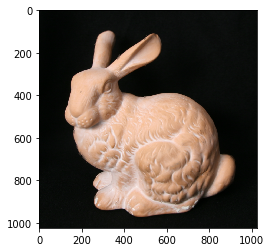

In [606]:
plt.imshow(lumigraph_render)
plt.show()

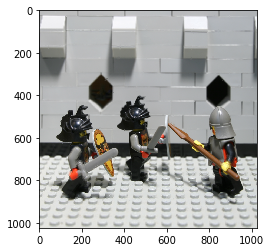

In [608]:
lumigraph_render = lumigraph_depth_correction(0.5, 8.5, z, dataset='lego')
plt.imshow(lumigraph_render)
plt.show()